<h1> <center> ENSF 519.01 Applied Data Scince </center></h1>
<h2> <center> Assignment 4: Unsupervised learning (25 marks)</center></h2>
<h2> <center> Due: Macrh 23 . To be submitted on D2L Dropbox </center></h2>


In this assignment the focus is on using unsupervised learning e.g., clustering and data transformation to get better understanding of the data (exploratory analysis) or predictions.  


<h2>Part A. Local VS. Global Prediction (7 marks)</h2>
<br><br>
In many situations, your training dataset is very large to include as many observations as possible, which is typically a good thing. For instance, a complex prediction model for image captioning works best if the learning dataset is massive and rich. However, if you are using a simple model (like a linear regression) for any reason (e.g., speed, interpretability, etc.) one caveat of very large datasets is that they might actually become very far off from your test set.
For instance, assume you have to predict online sales for a particular book. But your training set is the entire Amazon’s historical sales records. Obviously a simple linear model will not work well, trying to fit a line that predicts sales of everything, from books, to grocery, to toys, etc.

One simple solution could be trying to train your model only on a portion of the training set that is closer to your interested data. For instance, in the above example, only train on the book records. 

In this part of HW4, we want to evaluate this idea automatically, by first clustering the training dataset and then fitting the model only on the closets cluster to the test data.


So you need to follow these steps: 

- Read data from OO-DefectPrediction.csv dataset (used in HW3 for defect prediction)
- Take 90% of data as train and 10% as test using train_test_split with random_state=0. 
- Cluster the training set to multiple clusters using Kmeans. (K from 2 to 5, inclusive)
- Find the most similar cluster to the test set. To do this predict the data set items and see which cluster they fall in. Then use the majority vote to decide which cluster is closer to the test data (basically the one that is predicted most, as label, for the test data items)
- Build a global prediction model the same as the one you built in HW 3 PartB (using original entire train set)
- Build a local linear regression model where you use only the closets cluster as your train dataset (all other setups unchanged). 
- Compare the result (r2_score) between the global and the local model for each K and explain your observations.


In [1]:
## Part A. Solution

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import pandas as pd
%matplotlib inline

def CSV_Reader(Filename):
    data_target=pd.read_csv(Filename)
    data_cleaned=data_target.dropna()
    return [data_cleaned.iloc[:,:-1],data_cleaned.iloc[:,-1]]

def Score(Predictions,Lables):
    return r2_score(Lables,np.round(Predictions))

def most_common(a):
    counts = np.bincount(a)
    return np.argmax(counts)


features,lables=CSV_Reader("OO-DefectPrediction.csv")
X_train, X_test, y_train, y_test = train_test_split(features, lables, test_size=0.1, random_state=0)

lr_model=LinearRegression().fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("*"*4,"Global Linear Regression","*"*4)
print("R^2 on test set: {:.3f}\n".format(Score(lr_preds, y_test)))

for k in range(2,6):
    
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(X_train)

    TestLabels=kmeans.predict(X_test)
    LocalCluster=TestLabels[most_common(TestLabels)]

    otherClusters=[i for i,cluster in enumerate(kmeans.labels_)if cluster != LocalCluster]

    local_X_train=X_train.drop(X_train.index[otherClusters])
    local_y_train=y_train.drop(y_train.index[otherClusters])

    local_lr_model=LinearRegression().fit(local_X_train, local_y_train)
    local_lr_preds = local_lr_model.predict(X_test)

    print("*"*4,"Local Linear Regression with K=",k,"*"*4)
    print("R^2 on test set: {:.3f}\n".format(Score(local_lr_preds, y_test)))


**** Global Linear Regression ****
R^2 on test set: 0.114

**** Local Linear Regression with K= 2 ****
R^2 on test set: 0.353

**** Local Linear Regression with K= 3 ****
R^2 on test set: -0.098

**** Local Linear Regression with K= 4 ****
R^2 on test set: -1.278

**** Local Linear Regression with K= 5 ****
R^2 on test set: -1.495



<b>Question: Explain your observation in terms of R^2 of global and local models across different Ks?


<b>Your Answer:</b> We observe that the R^2 score is better when we localize the the data with kmeans k=2 compared to the case that we take all the data to train the model. But for k=3,4,... we see that the localization makes the result worst as the local data gets too small and cannot train the model as good as before. 

<h2>Part B. Analyze Clustering Algorithms (8 marks) </h2>
In this part, you will excerise the same type of cluster analysis we tried in class, but this time on a different dataset (Movie Dataset)

Preprocessing Steps (2 mark):
- Read data from "movie_metadata.csv" 
- Remove duplicate movies (same title), if any exists
- Keep only these columns ['director_name', 'actor_1_name', 'budget', 'imdb_score'] as features
- Remove any row that has an empty feature, among those we have kept
- Use one-hot-encoding in Pandas to transfer categorical data
- Finally, scale both 'budget' and 'imdb_score' features using MinMaxScaler 


In [2]:
## Part B. Preprocessing 

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def Read_Table(Filename):
    data_target=pd.read_csv(Filename)
    print("Cleaning data ...")
    data_cleaned=data_target.dropna().drop_duplicates()
    return data_cleaned
    
def DataScaler(Data,Columns,Scaler):
    print("Scaling Data ...")
    NewScaledDF=Data.copy(deep=True)
    for column in Columns:
        MyScaler = Scaler()
        scaledColumn = MyScaler.fit_transform(Data[column].values.reshape(-1, 1))
        NewScaledDF[column]=scaledColumn
    return NewScaledDF

Data=Read_Table("movie_metadata.csv")
Data.set_index('movie_title', inplace=True)


ScaledData=DataScaler(Data,['budget','imdb_score'],MinMaxScaler)

print("On-Hot-Encoding in process ...")
data_dummies = pd.get_dummies(Data)
scaled_data_dummies = pd.get_dummies(ScaledData)

print("Preprocessing Done !")

Cleaning data ...
Scaling Data ...
On-Hot-Encoding in process ...
Preprocessing Done !


<h3>Part B.1 Tune DBSCAN (2 marks) </h3>

Now apply a DBSCAN clustering algorithm on the preprocessed data.
Tune DBSCAN using eps : [0.5, 1, 1.5, 2] and min_sample: [3, 5, 10].
For each setup, print Number of clusters, Cluster sizes, and number of noises.



In [24]:
## Part B.1 DBSCAN 

from sklearn.cluster import DBSCAN

for minSample in [3, 5, 10]:
    for eps in [0.5, 1, 1.5, 2]:
        print("\neps={}".format(eps))
        print("minSample={}".format(minSample))
        dbscan = DBSCAN(eps=eps, min_samples=minSample)
        labels = dbscan.fit_predict(scaled_data_dummies)
        print("Number of clusters: {}".format(len(np.unique(labels))))
        print("Cluster sizes: {}".format(np.bincount(labels + 1)))
        print("Number of Noise data points: {}\n ************\n".format(np.bincount(labels + 1)[0]))


eps=0.5
minSample=3
Number of clusters: 43
Cluster sizes: [4258   10    6    3    3    4   10    3    3    3    4    4    3    7    3
    3    4    3    5    4    5    4    3    3    4    3    3    4    4    3
    3    4    3    3    5    3    4    3    3    3    3    3    3]
Number of Noise data points: 4258
 ************


eps=1
minSample=3
Number of clusters: 43
Cluster sizes: [4258   10    6    3    3    4   10    3    3    3    4    4    3    7    3
    3    4    3    5    4    5    4    3    3    4    3    3    4    4    3
    3    4    3    3    5    3    4    3    3    3    3    3    3]
Number of Noise data points: 4258
 ************


eps=1.5
minSample=3
Number of clusters: 40
Cluster sizes: [ 725 3568    3    3    4    3    3    3    3    3    3    6    3    4    5
    3    3    4    5    3    3    3    4    3    4    5    4    3    3    3
    3    3    3    3    3    3    3    3    3    3]
Number of Noise data points: 725
 ************


eps=2
minSample=3
Number of clusters

Explain your observations.

<b>Your Answer:</b> We have two extrem specification: 1-{eps=2 minSample=3} in wich we have more clusters with small sizes and 2-{eps=0.5 minSample=10} in which the clusters are more stricted and we can see that all the datapoints are considered as noise. All other specifications fall between these two.

<h3>Part B.2 Scaling effect on the output (2 marks) </h3>

To see the effect of scaling, run DBSCAN twice. Once on the scaled data and once with the original 'budget' and 'imdb_score' values. In both cases, use the following setup (eps=2, min_samples=3).
Print cluster sizes as well as the actual cluster members (the movie title plus all its features). 


In [31]:
## Part B.2 Scaling effect on the Output

from sklearn.cluster import DBSCAN

print("\t"+"*"*40)
print("\t"+"*"*40)
print("\t********Result on original Data********")
print("\t"+"*"*40)
print("\t"+"*"*40)

Original_dbscan = DBSCAN(eps=2, min_samples=3)
Original_labels = Original_dbscan.fit_predict(data_dummies)
print("Number of clusters: {}".format(len(np.unique(Original_labels))))
print("Cluster sizes: {}".format(np.bincount(Original_labels + 1)))
print("Number of Noise data points: {}\n ************\n".format(np.bincount(Original_labels + 1)[0]))

for j in range(1,len(np.unique(Original_labels))):
#     to remove <6 condition, just remove the line below    
    if np.bincount(Original_labels + 1)[j]<6:
        print(Data.iloc[[i for i in range(len(Original_labels)) if Original_labels[i]==j]])
        print("**********")

print("\n"*10)        
print("\t"+"*"*40)
print("\t"+"*"*40)
print("\t********Result on Scaled Data********")
print("\t"+"*"*40)
print("\t"+"*"*40)

Scaled_dbscan = DBSCAN(eps=2, min_samples=3)
Scaled_labels = Scaled_dbscan.fit_predict(scaled_data_dummies)
print("Number of clusters: {}".format(len(np.unique(Scaled_labels))))
print("Cluster sizes: {}".format(np.bincount(Scaled_labels + 1)))
print("Number of Noise data points: {}\n ************\n".format(np.bincount(Scaled_labels + 1)[0]))

for j in range(1,len(np.unique(Scaled_labels))):
#     to remove <6 condition, just remove the line below
    if np.bincount(Scaled_labels + 1)[j]<6:
        print(ScaledData.iloc[[i for i in range(len(Scaled_labels)) if Scaled_labels[i]==j]])
        print("**********")

	****************************************
	****************************************
	********Result on original Data********
	****************************************
	****************************************
Number of clusters: 318
Cluster sizes: [2367   88   50   56    3    9   10    5    4    7   65  104    4    4    3
    4   39    3    9    3    5    5   24    7    4    6    4    4   88    4
    3    6    8    6   59    4    3    4    3    5    5    5    4    4    4
    5    4    3    4    3    6    3    4    4    3    6    6    3   13    3
   13    3    3    4    6   10    9    5    3    4    6    3    4    5    4
   32   15    7   42    5   11    4    6    3   12    5    4    4    4    3
    3    3    3    3    4   26    5    5    3   11    9    3   31    3    3
    5    3    3   10   18    3    3    3    4    3    4    4    8    3    6
    5    4    4   32    4    4    5    3    3    4    4    4    3    5    4
    6    3    3    6    5    3    3    3    4    9    3    3   10   

**********
                                      director_name       actor_1_name  \
movie_title                                                              
5 Days of War                          Renny Harlin      Richard Coyle   
A Guy Thing                              Chris Koch      Thomas Lennon   
Alpha and Omega                        Anthony Bell      Kevin Sussman   
Burnt                                    John Wells     Bradley Cooper   
Copycat                                   Jon Amiel   William McNamara   
Daybreakers                         Michael Spierig       Jay Laga'aia   
De-Lovely                             Irwin Winkler      Kevin McNally   
Home for the Holidays                  Jodie Foster  Robert Downey Jr.   
Loser                                Amy Heckerling          Andy Dick   
Machete Kills                      Robert Rodriguez     Alexa PenaVega   
Never Back Down                         Jeff Wadlow     Djimon Hounsou   
Passchendaele              

**********
                            director_name   actor_1_name      budget  \
movie_title                                                            
Babel               Alejandro G. Iñárritu      Brad Pitt  25000000.0   
Elizabeth                   Shekhar Kapur   Fanny Ardant  25000000.0   
Tora! Tora! Tora!       Richard Fleischer  Joseph Cotten  25000000.0   

                    imdb_score  
movie_title                     
Babel                      7.5  
Elizabeth                  7.5  
Tora! Tora! Tora!          7.5  
**********
                                director_name  actor_1_name      budget  \
movie_title                                                               
Baby Mama                   Michael McCullers      Tina Fey  30000000.0   
Doomsday                        Neil Marshall   Ryan Kruger  30000000.0   
Jimmy Neutron: Boy Genius       John A. Davis  Martin Short  30000000.0   
The Corruptor                     James Foley    Byron Mann  30000000.0   

 

Number of clusters: 7
Cluster sizes: [ 389 4017    3    4    3    3    3]
Number of Noise data points: 389
 ************

                        director_name       actor_1_name    budget  imdb_score
movie_title                                                                   
Agora              Alejandro Amenábar      Max Minghella  0.005730    0.727273
The Darkest Hour          Chris Gorak      Max Minghella  0.002456    0.428571
The Others         Alejandro Amenábar  Fionnula Flanagan  0.001392    0.779221
The Sea Inside     Alejandro Amenábar        Belén Rueda  0.000819    0.844156
**********
                     director_name     actor_1_name    budget  imdb_score
movie_title                                                              
Annie Get Your Gun   George Sidney      Keenan Wynn  0.000309    0.701299
Bathing Beauty       George Sidney  Esther Williams  0.000193    0.636364
Show Boat            George Sidney  Agnes Moorehead  0.000188    0.701299
**********
            

Explian how the data points have been clustered and whether scaling was necessary.

<b>Your Answer:</b> before scaling values of both 'budget'and 'imdb_score' are in a wider range, as a result the clusterer tends to gather the datapoints based on different values of these two columns. However scaling helps to reduce the effect of these two columns to do the clustering in a more meaningful way. 

<h3>Part B.3 KMeans and Agglomerative Clustering  (2 marks) </h3>
In this section, use the scaled dataset and first draw a dendrogram using ward function in scipy. Explian why K= 10 seems like a good choice.
Comapre ARI of KMeans and agglomerative using K=5.

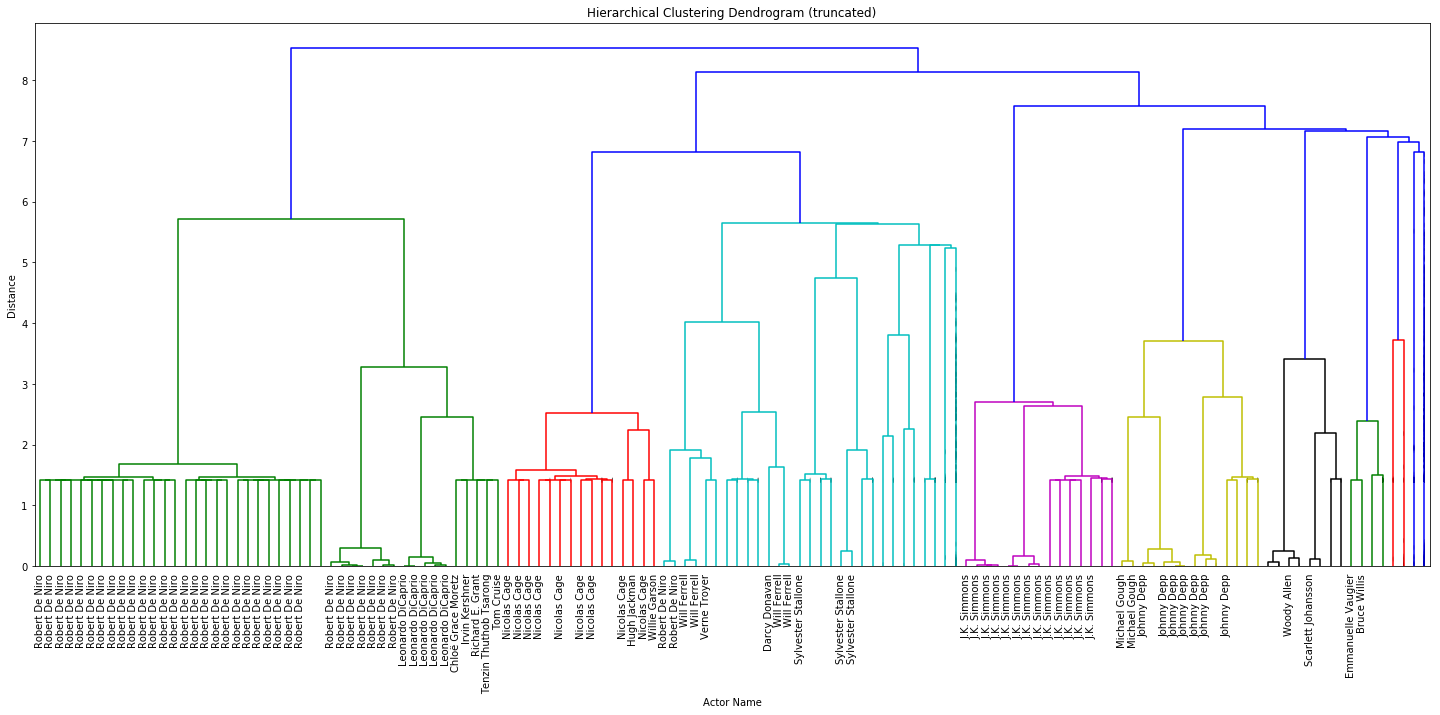

In [32]:
## Part B.3 KMeans and Agglomerative

from scipy.cluster.hierarchy import dendrogram, ward

linkage_array = ward(scaled_data_dummies)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Actor Name')
plt.ylabel('Distance')
dendrogram(linkage_array,labels=ScaledData['actor_1_name'],truncate_mode='level',p=7,show_leaf_counts=False,leaf_rotation=90.,leaf_font_size=10.,show_contracted=True,)
plt.show()

In [34]:
# ARI comparison of KMeans and agglomerative using K=10

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

kmeansModel = KMeans(n_clusters=10,random_state=0).fit(scaled_data_dummies).fit_predict(scaled_data_dummies)
agglomerative = AgglomerativeClustering(n_clusters=10).fit_predict(scaled_data_dummies)

print("ARI comparison of kmeans and agglomerative: {}".format(adjusted_rand_score(kmeansModel, agglomerative)))


ARI comparison of kmeans and agglomerative: 0.11884691750287288


<h1>Part C. Feature Selection (6 marks)</h1>
<br>

In this section, we are going to select the most informative features from the NASA dataset.


<h2>Part C.1. Feature selection using ANOVA (3 marks)</h2>

Steps:
    
- Read data from the NASA.csv
- Using ANOVA select top K features, whith K=[1..10]
- Build LogisticRegression models, one with the original data, and one for each K (using a subset of feature)
- Compare the accuracies and find the best K (use random_state=0)


In [37]:
## Part C.1 ANOVA 

## Part C.1 Solution

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

features,lables=CSV_Reader("NasaData.csv")

X_train, X_test, y_train, y_test = train_test_split(features, lables, random_state=0, test_size=.25)

lr = LogisticRegression().fit(X_train, y_train)
print("LogisReg: ",lr.score(X_test, y_test))

for K in range(1,11):

    ANOVA_select = SelectKBest(k=K).fit(X_train, y_train)
    X_train_selected = ANOVA_select.transform(X_train)
    X_test_selected = ANOVA_select.transform(X_test)
    slr = LogisticRegression().fit(X_train_selected, y_train)
    print("ANOVA k="+str(K)+": ", slr.score(X_test_selected, y_test))
        




LogisReg:  0.799075025694
ANOVA k=1:  0.795477903392
ANOVA k=2:  0.795477903392
ANOVA k=3:  0.794964028777
ANOVA k=4:  0.794450154162
ANOVA k=5:  0.795477903392
ANOVA k=6:  0.795991778006
ANOVA k=7:  0.795991778006
ANOVA k=8:  0.796505652621
ANOVA k=9:  0.796505652621
ANOVA k=10:  0.794964028777


<h2>Part C.2. Compare feature selection models (3 marks)</h2>

Now apply SelectFromModel and RFE and compare them with SelectKBest, as follows:

- Apply the three techniques so that you reduce the features to only 6 features (note that 6 is not necessarily the best K from Part C.1)
- Report the prediction scores of a LogisticRegression model on the selected features of each model.
- Print the name of features selected by each model.


	**** ANOVA ****
Features selected: **['LOC_BLANK', 'HALSTEAD_CONTENT', 'HALSTEAD_LENGTH', 'NUM_OPERANDS', 'NUM_UNIQUE_OPERANDS', 'LOC_TOTAL']**
** Test score: 0.796 **
**Data shape after selection: (5836, 6)**


	**** selectFromModel ****
Features selected: **['LOC_EXECUTABLE', 'HALSTEAD_CONTENT', 'HALSTEAD_EFFORT', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'LOC_TOTAL']**
** Test score: 0.794 **
**Data shape after selection: (5836, 6)**


	**** RFEselect ****
Features selected: **['HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'LOC_TOTAL']**
** Test score: 0.793 **
**Data shape after selection: (5836, 6)**




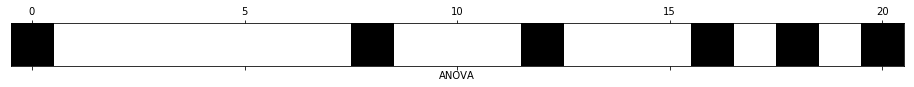

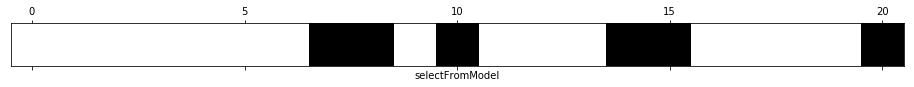

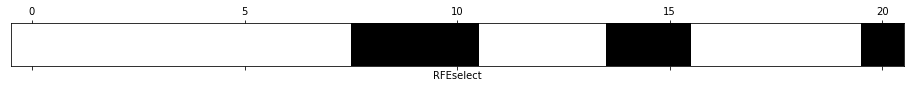

In [38]:
## Part C.2 Compare feature selection models 

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

def plot_selection(selectFeature,funcName,X_train, X_test, y_train, y_test):
    mask = selectFeature.get_support()
    print("\t**** "+funcName+" ****")
    print("Features selected: **{}**".format([list(features.columns.values)[i] for i in np.where(mask == True)[0]]))
    plt.matshow(mask.reshape(1, -1), cmap='gray_r')
    plt.xlabel(funcName)
    plt.yticks(())

    X_train_transformed = selectFeature.transform(X_train)
    X_test_transformed = selectFeature.transform(X_test)
    score = LogisticRegression().fit(X_train_transformed, y_train).score(X_test_transformed, y_test)
    print("** Test score: {:.3f} **".format(score))
    print("**Data shape after selection: {}**\n\n".format(X_train_transformed.shape))
    
    
features,lables=CSV_Reader("NasaData.csv")
X_train, X_test, y_train, y_test = train_test_split(features, lables, random_state=0, test_size=.25)

ANOVA_select = SelectKBest(k=6).fit(X_train, y_train)
plot_selection(ANOVA_select,"ANOVA",X_train, X_test, y_train, y_test)

selectFModel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0),threshold="1.25*mean").fit(X_train, y_train)
plot_selection(selectFModel,"selectFromModel",X_train, X_test, y_train, y_test)

RFEselect = RFE(RandomForestClassifier(n_estimators=100, random_state=0),n_features_to_select=6).fit(X_train, y_train)
plot_selection(RFEselect,"RFEselect",X_train, X_test, y_train, y_test)


<h1>Part D. Data Tranformation (4 marks)</h1>

In this part, you are going to work with a new data set which contains some the features of a house collected over time. 
The objective of this part is to help improve linear model's predicitons using data transformation.

<h2>Part D.1 Binning (2 marks)</h2>

Our first try is using binning, as follows:

- Read form MyHouse.csv (take 'Light' as the data target and the rest of the columns as data features ) 
- First apply a LinearRegression on the original data to predict the target and report the score of the model on the test set. 
- Now apply binning on all three columns 
 (for Temperature make 5 Bins -- for Humidity make 10 bins -- and for CO2Bins make 11 bins)
- Print your data shape before and after binning.
- Now again apply LinearRegression on the new data and report the score again. 



In [42]:
## Part D.1 Compare feature selection models 


from sklearn.preprocessing import OneHotEncoder

def Evaluate(features_one,features_two,lables,FunctionName):
    X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(features_one, lables, random_state=0, test_size=.25)
    X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(features_two, lables, random_state=0, test_size=.25)

    score_one = LinearRegression().fit(X_train_one, y_train_one).score(X_test_one, y_test_one)
    score_two = LinearRegression().fit(X_train_two, y_train_two).score(X_test_two, y_test_two)

    print("** Test score before "+FunctionName+": {:.3f} **".format(score_one))
    print("**Data shape before "+FunctionName+": {}**\n\n".format(X_train_one.shape))
    
    print("** Test score after "+FunctionName+": {:.3f} **".format(score_two))
    print("**Data shape after "+FunctionName+": {}**\n\n".format(X_train_two.shape))
    
features,lables=CSV_Reader("MyHouse.csv")

TemperatureBins = np.linspace(20, 25, 6)
HumidityBins = np.linspace(22, 32, 11)
CO2Bins = np.linspace(400,1500,12)

features['Temperature'] = np.digitize(features['Temperature'], bins=TemperatureBins)
features['Humidity'] = np.digitize(features['Humidity'], bins=HumidityBins)
features['CO2'] = np.digitize(features['CO2'], bins=CO2Bins)

TemperatureEncoder = OneHotEncoder(sparse=False)
TemperatureEncoder.fit(features['Temperature'].values.reshape(-1, 1))
TemperatureBinned = pd.DataFrame(TemperatureEncoder.transform(features['Temperature'].values.reshape(-1, 1)))
TemperatureBinned.columns = ["Temperature:"+str(i)+"to"+str(i+1) for i in range(20, 25)]

HumidityEncoder = OneHotEncoder(sparse=False)
HumidityEncoder.fit(features['Humidity'].values.reshape(-1, 1))
HumidityBinned = pd.DataFrame(HumidityEncoder.transform(features['Humidity'].values.reshape(-1, 1)))
HumidityBinned.columns = ["Humidity:"+str(i)+"to"+str(i+10) for i in range(22, 32, 1)]


CO2Encoder = OneHotEncoder(sparse=False)
CO2Encoder.fit(features['CO2'].values.reshape(-1, 1))
CO2Binned = pd.DataFrame(CO2Encoder.transform(features['CO2'].values.reshape(-1, 1)))
CO2Binned.columns = ["CO2:"+str(i)+"to"+str(i+100) for i in range(400,1500,100)]

binnedFeatures=pd.concat([TemperatureBinned,HumidityBinned,CO2Binned], axis=1)

Evaluate(features,binnedFeatures,lables,"Binning")

** Test score before Binning: 0.675 **
**Data shape before Binning: (1998, 3)**


** Test score after Binning: 0.815 **
**Data shape after Binning: (1998, 26)**




<h2>Part D.2 Polynomials (2 marks)</h2>

To compare polynomials and binning, apply polynomials on all three features. 
- Use degree=6.
- Print your data shape before and after transformation
- Apply LinearRegression on the new data and report the score again. 


In [43]:
## Part D.2 Compare feature selection models 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression


features,lables=CSV_Reader("MyHouse.csv")

TemperaturePoly = PolynomialFeatures(degree=6, include_bias=False).fit(features['Temperature'].values.reshape(-1, 1))
Temperature_poly_transformed = pd.DataFrame(TemperaturePoly.transform(features['Temperature'].values.reshape(-1, 1)))
Temperature_poly_transformed.columns = ["Temperature^"+str(i) for i in range(1,7)]

HumidityPoly = PolynomialFeatures(degree=6, include_bias=False).fit(features['Humidity'].values.reshape(-1, 1))
Humidity_poly_transformed = pd.DataFrame(HumidityPoly.transform(features['Humidity'].values.reshape(-1, 1)))
Humidity_poly_transformed.columns = ["Humidity^"+str(i) for i in range(1,7)]

CO2Poly = PolynomialFeatures(degree=6, include_bias=False).fit(features['CO2'].values.reshape(-1, 1))
CO2_poly_transformed = pd.DataFrame(CO2Poly.transform(features['CO2'].values.reshape(-1, 1)))
CO2_poly_transformed.columns = ["CO2^"+str(i) for i in range(1,7)]

Features_poly_transformed=pd.concat([Temperature_poly_transformed,Humidity_poly_transformed,CO2_poly_transformed], axis=1)

Evaluate(features,Features_poly_transformed,lables,"polynomial")

** Test score before polynomial: 0.692 **
**Data shape before polynomial: (1998, 3)**


** Test score after polynomial: 0.814 **
**Data shape after polynomial: (1998, 18)**


